<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import patsy
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV, SGDRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
import statsmodels.formula.api as sm
from sklearn.feature_selection import RFECV

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

<h3>Checking and cleaning the data</h3>

In [3]:
# A:
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


**Drop redundant Id column**

In [4]:
house.drop('Id', axis=1, inplace=True)

**Remove non-residential houses**

In [5]:
house['MSZoning'].unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

In [6]:
house.drop(house[house['MSZoning'] == 'C (all)'].index, inplace=True)

In [7]:
house['MSZoning'].unique()

array(['RL', 'RM', 'FV', 'RH'], dtype=object)

**Check that the datatypes are correct**

In [8]:
def checkColValue(df, cols, dtype):
    """
        Function to check whether the dtype of a column is correct
        
        Parameters:
        -----------
        df: Dataframe
            Dataframe which contains the columns to check
        cols: list
            A list of column names to check against the dtype
        dtype: list of data-types
            Type that is expected of the column
    """
    for col in cols:
        if df[col].dtypes not in dtype:
            print (f"{col} supposed to be {dtype}. Found {df[col].dtypes}")

In [9]:
cols_numeric = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 
                'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
               'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
               '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
               'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
               'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
                'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
               'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
               'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']

In [10]:
checkColValue(house, cols_numeric, [int, float])

*The columns which are supposed to contain numeric values are of the correct data types.*

**Clean up the null values**

In [11]:
null_sum = house.isnull().sum()
null_sum[null_sum > 0]

LotFrontage      259
Alley           1361
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      681
GarageType        79
GarageYrBlt       79
GarageFinish      79
GarageQual        79
GarageCond        79
PoolQC          1443
Fence           1172
MiscFeature     1398
dtype: int64

* LotFrontage: impute the missing values so that it can be used in the regression later
* Alley: null values should be converted to string 'NA' because it represents no alley access
* MasVnrType: null values should be converted to string 'None' because it represents no veneer type
* MasVnrArea: null values should be converted to zero because it represents that there is no masonry veneer (this is consistent with the other rows when the masonry veneer type is 'None'
* BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2: null values should be converted to string 'NA' because it represents no basement
* Electrical: 1 null value (reasonable to convert it to the category which occurs most frequently)
* FireplaceQu: null values should be converted to string 'NA' because it represents no fireplace
* GarageType, GarageFinish, GarageQual, GarageCond: null values should be converted to string 'NA' because it represents no garage
* GarageYrBlt: leave as null
* PoolQC: null values should be converted to string 'NA' because it represents no pool
* Fence: null values should be converted to string 'NA' because it represents no fence
* MiscFeature: null values should be converted to string 'NA' because it represents no miscellaneous feature

In [12]:
cols_string_na = ['Alley', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
        'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
        'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

In [13]:
subset = house[cols_string_na].fillna('NA')
house[cols_string_na] = subset

In [14]:
subset = house['MasVnrType'].fillna('None')
house['MasVnrType'] = subset

In [15]:
subset = house['MasVnrArea'].fillna(0)
house['MasVnrArea'] = subset

In [16]:
subset = house['Electrical'].fillna(house['Electrical'].mode().values[0])
house['Electrical'] = subset

**Impute missing values in LotFrontage**

I am grouping the houses by LotConfig and taking the median LotFrontage in each group. The rationale is that the configuration of the lot would affect the front part of the lot (which is the LotFrontage). I am using the median so that the value is more robust to a skewed distribution

In [17]:
lot_frontage_medians = house.groupby(['LotConfig']).median()['LotFrontage']

In [18]:
def imputeFrontage(row):
    return lot_frontage_medians[row['LotConfig']]
    
house.loc[house['LotFrontage'].isnull(), 'LotFrontage'] = house[house['LotFrontage'].isnull()].apply(imputeFrontage, axis=1)

**Check for validity of data (eg. any negative values)**

In [19]:
def checkNegValues(df, cols):
    """
        Function to check if there are negative values in the columns
        
        Parameters:
        -----------
        df: Dataframe
            Dataframe which contains the columns to check
        cols: list
            A list of column names to check
    """
    neg_cols = (df[cols] < 0).sum()
    neg_col_names = neg_cols[neg_cols > 0].index
    if len(neg_col_names) > 0:
        print (neg_col_names)
    else: 
        print ("There are no negative values in the columns")

In [20]:
checkNegValues(house, cols_numeric)

There are no negative values in the columns


In [21]:
def checkZeroValues(df, cols):
    """
        Function to check if there are zero values in the columns
        
        Parameters:
        -----------
        df: Dataframe
            Dataframe which contains the columns to check
        cols: list
            A list of column names to check
    """
    zero_cols = (df[cols] == 0).sum()
    zero_col_names = zero_cols[zero_cols > 0].index
    if len(zero_col_names) > 0:
        print (zero_col_names)
    else: 
        print ("There are no zero values in the columns")

In [22]:
noZeroValueCol = ['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
                 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold',
                 '1stFlrSF', 'SalePrice']

In [23]:
checkZeroValues(house, noZeroValueCol)

There are no zero values in the columns


**Check for consistency of data between columns**

In [24]:
house[(house['MasVnrType'] == 'None') & (house['MasVnrArea'] != 0)][['MasVnrType', 'MasVnrArea']]

,MasVnrType,MasVnrArea
624,None,288.0
773,None,1.0
1230,None,1.0
1300,None,344.0
1334,None,312.0


*There should be a masonry veneer type if the masonry veneer area is non zero. Leaving it as None because there is no way to deduce the type.*

In [25]:
house[(house['BsmtFinType1'] == 'NA') & (house['BsmtFinSF1'] != 0)][['BsmtFinType1', 'BsmtFinSF1']]

,BsmtFinType1,BsmtFinSF1


*There is no discrepancy in the basement finished type 1.*

In [26]:
house[(house['BsmtFinType2'] == 'NA') & (house['BsmtFinSF2'] != 0)][['BsmtFinType2', 'BsmtFinSF2']]

,BsmtFinType2,BsmtFinSF2
332,NA,479


*There should be a basement finished area rating if the basement finished area is non zero. Leaving it as NA because there is no way to deduce the rating.*

In [27]:
house[(house['BsmtExposure'] == 'NA') & (house['TotalBsmtSF'] != 0)][['BsmtExposure', 'TotalBsmtSF']]

,BsmtExposure,TotalBsmtSF
948,NA,936


*There should be a basement exposure when the basement area is non zero. Leaving it as NA beacause there is no way to deduce the exposure.*

In [28]:
(house['BsmtFinSF1'] + house['BsmtFinSF2'] + house['BsmtUnfSF'] != house['TotalBsmtSF']).sum()

0

*There is no discrepancy in the basement area data.*

In [29]:
house[(house['Fireplaces'] == 0) & (house['FireplaceQu'] != 'NA')][['Fireplaces', 'FireplaceQu']]

,Fireplaces,FireplaceQu


*There is no discrepancy in the fireplace data.*

In [30]:
house[house['GarageType'] == 'NA'][['GarageCars', 'GarageArea']].sum()

GarageCars    0
GarageArea    0
dtype: int64

*There is no discrepancy in the garage data.*

In [31]:
house[(house['PoolArea'] == 0) & (house['PoolQC'] != 'NA')][['PoolArea', 'PoolQC']]

,PoolArea,PoolQC


*There is no discrepancy in the pool data.*

In [32]:
house[(house['MiscFeature'] == 'NA') & (house['MiscVal'] != 0)][['MiscFeature', 'MiscVal']]

,MiscFeature,MiscVal


*There is no discrepancy in the miscellaneous feature data.*

<h3>EDA</h3>

In [33]:
# These are the fixed characteristics of a house
fixed = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 
         'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 
         'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 
         'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt', 
         'YearRemodAdd', 'Foundation', 'BsmtQual', 'BsmtExposure', 
         'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath',
         'BsmtHalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
         'GarageType', 'GarageYrBlt', 'GarageCars', 'GarageArea', 
         'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
         'ScreenPorch', 'PoolArea', 'MiscFeature', 'MiscVal']
         

In [34]:
house[fixed].describe()

,MSSubClass,LotFrontage,LotArea,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,...,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
count,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,...,1371.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000
mean,56.903448,69.552414,10523.831724,1971.593103,1985.049655,1059.408966,1164.773103,347.394483,1517.698621,0.427586,...,1978.627279,1.770345,473.277931,94.826897,46.537931,21.536552,3.433103,15.096552,2.777931,43.365517
std,42.265033,22.434546,10012.185355,30.022696,20.552319,439.207322,386.646095,437.094261,525.154207,0.519394,...,24.592779,0.745136,212.687621,125.560863,65.222761,60.838826,29.416948,55.893399,40.315051,497.636495
min,20.000000,21.000000,1300.000000,1872.000000,1950.000000,0.000000,334.000000,0.000000,334.000000,0.000000,...,1906.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,60.000000,7544.500000,1954.000000,1967.000000,796.000000,882.500000,0.000000,1131.250000,0.000000,...,1961.500000,1.000000,336.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.000000,68.000000,9496.000000,1973.000000,1994.000000,992.000000,1088.000000,0.000000,1466.000000,0.000000,...,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,70.000000,80.000000,11613.500000,2001.000000,2004.000000,1301.500000,1392.000000,728.000000,1779.000000,1.000000,...,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,190.000000,313.000000,215245.000000,2010.000000,2010.000000,6110.000000,4692.000000,2065.000000,5642.000000,3.000000,...,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000


**Exploring the correlation**

In [35]:
def listCorrelationPairs(corr, descending=True, n=None, threshold=None):
    """
        Function to list the first `n` correlation pairs
        
        Parameters:
        -----------
        corr: Dataframe
            Dataframe which contains correlation values
        threshold: float, default = None
            Correlation magnitude above the threshold will be shown
        n: int, default = None
            Number of correlation pairs to show
        descending: bool, default = True
            Sort the correlation pairs in descending order according to 
            magnitude
            
        Returns:
        -----------
        corr_pairs: dict
            First `n` correlation pairs
    """
    corr_len = len(corr)
    x1 = []
    x2 = []
    corr_value = []
    corr_mag = []
    for i in range(corr_len):
        for j in range(i+1, corr_len):
            x1.append(corr.columns[i])
            x2.append(corr.columns[j])
            corr_value.append(corr.iloc[i,j])
            corr_mag.append(np.abs(corr.iloc[i,j]))
            
    corr_pairs = pd.DataFrame({'x1': x1, 'x2': x2, 'correlation': corr_value,
                          'magnitude': corr_mag})
    if (threshold):
        corr_pairs = corr_pairs[corr_pairs['magnitude'] >= threshold]
    corr_pairs.sort_values('magnitude', ascending=not descending,
                           inplace=True)
    
    if (n):
        return corr_pairs.head(n)
    return corr_pairs
            

In [36]:
fixed_target = fixed + ['SalePrice']
corr_pairs = listCorrelationPairs(house[fixed_target].corr())

In [37]:
# Getting the list of correlation between fixed characteristic and sale price
corr_pairs[corr_pairs['x2'] == 'SalePrice']

,x1,x2,correlation,magnitude
188,GrLivArea,SalePrice,0.708658,0.708658
288,GarageCars,SalePrice,0.642135,0.642135
296,GarageArea,SalePrice,0.629831,0.629831
134,TotalBsmtSF,SalePrice,0.612088,0.612088
153,1stFlrSF,SalePrice,0.603300,0.603300
258,TotRmsAbvGrd,SalePrice,0.533355,0.533355
93,YearBuilt,SalePrice,0.517602,0.517602
114,YearRemodAdd,SalePrice,0.501186,0.501186
279,GarageYrBlt,SalePrice,0.486058,0.486058
269,Fireplaces,SalePrice,0.463264,0.463264


/Users/joshuamei/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


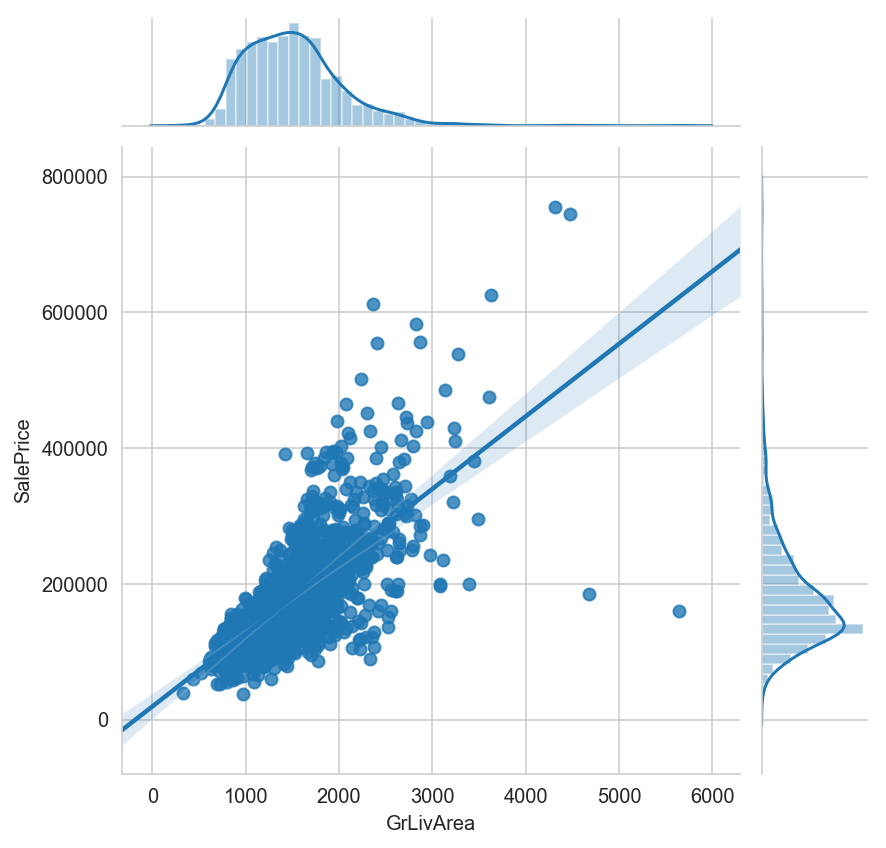

In [38]:
sns.jointplot(house[('GrLivArea')], house[('SalePrice')], kind='reg')
plt.show()

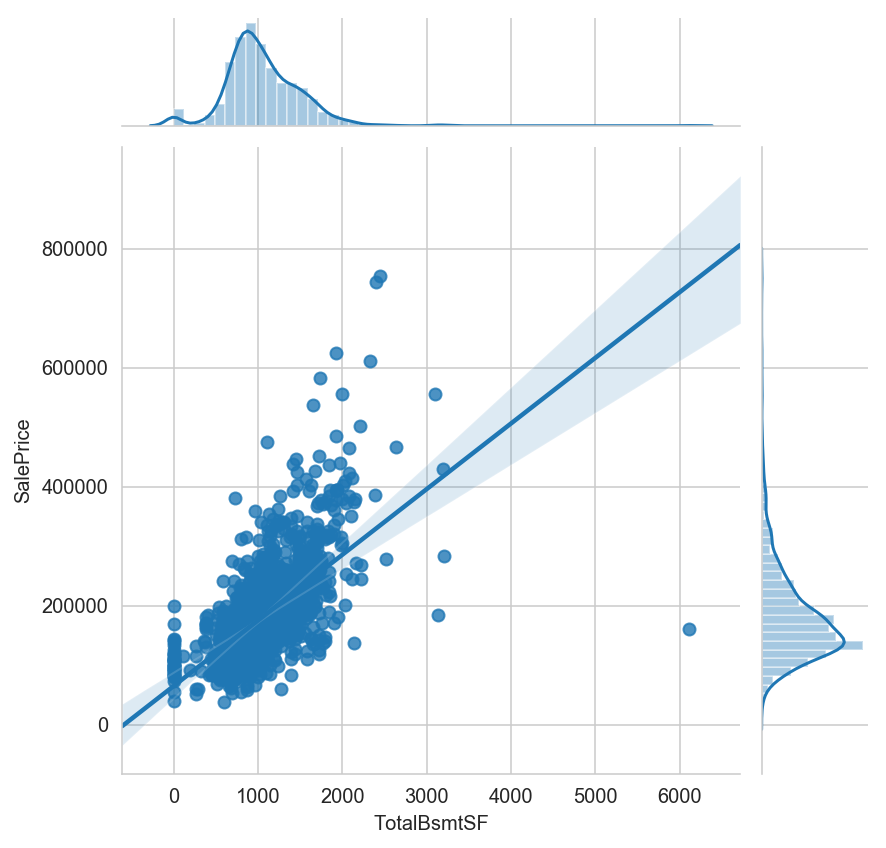

In [39]:
sns.jointplot(house['TotalBsmtSF'], house['SalePrice'], kind='reg')
plt.show()

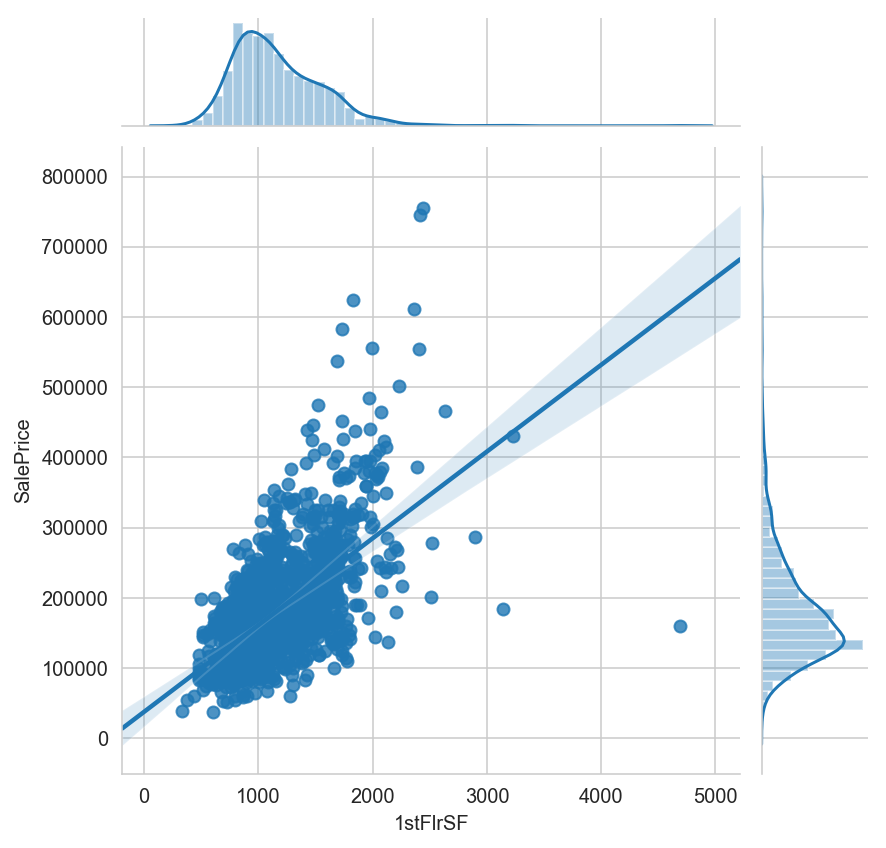

In [40]:
sns.jointplot(house['1stFlrSF'], house['SalePrice'], kind='reg')
plt.show()

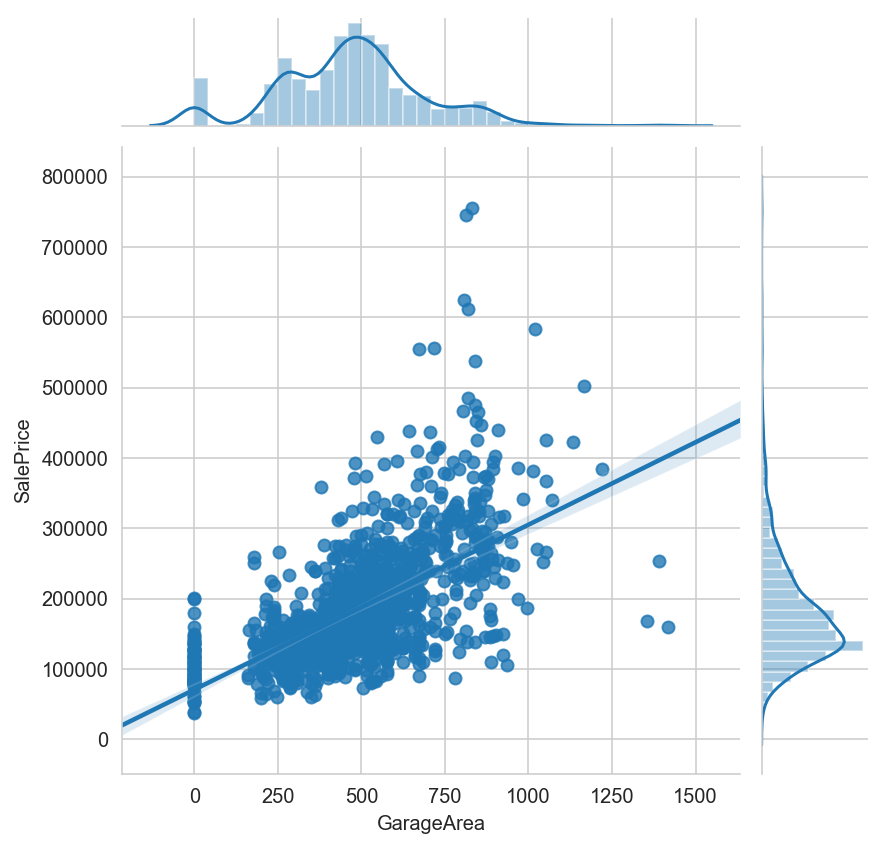

In [41]:
sns.jointplot(house['GarageArea'], house['SalePrice'], kind='reg')
plt.show()

From the correlation values, we can see that `GrLivArea`, `GarageCars`, `GarageArea`, `TotalBsmtSF` and `1stFlrSF` have a relatively strong positive linear correlation with `SalePrice`. These variables could be good predictors of the sale price.

From the plots, we can also observe that there is indeed some linear correlation between these variables and sale price. However, the values when `GarageArea = 0` and `TotalBsmtSF = 0` is skewing the regression line. Furthermore, there seems to be some outliers that might be affecting the linear regression as well. There are houses with GrLivArea > 4000 which are skewing the regression line in the first three plots. (In fact, while doing cross validation in the later section, it was observed that the $R^2$ scores in 2 folds were lower than the rest of the scores. After removing the outliers, the $R^2$ scores were consistent in all folds.) Three of the outliers also belonged to partial/abnormal sales which could reasonably be excluded from the model (since most sales would be normal sales).

In [42]:
house.drop(house[house['GrLivArea'] > 4000].index, inplace=True)

**Checking for the outliers**

In [43]:
fixed_numeric_col = house[fixed_target].corr().columns

In [44]:
# Standardize the variables so that they can be plotted on the same chart
fixed_numeric_scaled = (house[fixed_numeric_col] - house[fixed_numeric_col].mean()) / house[fixed_numeric_col].std()

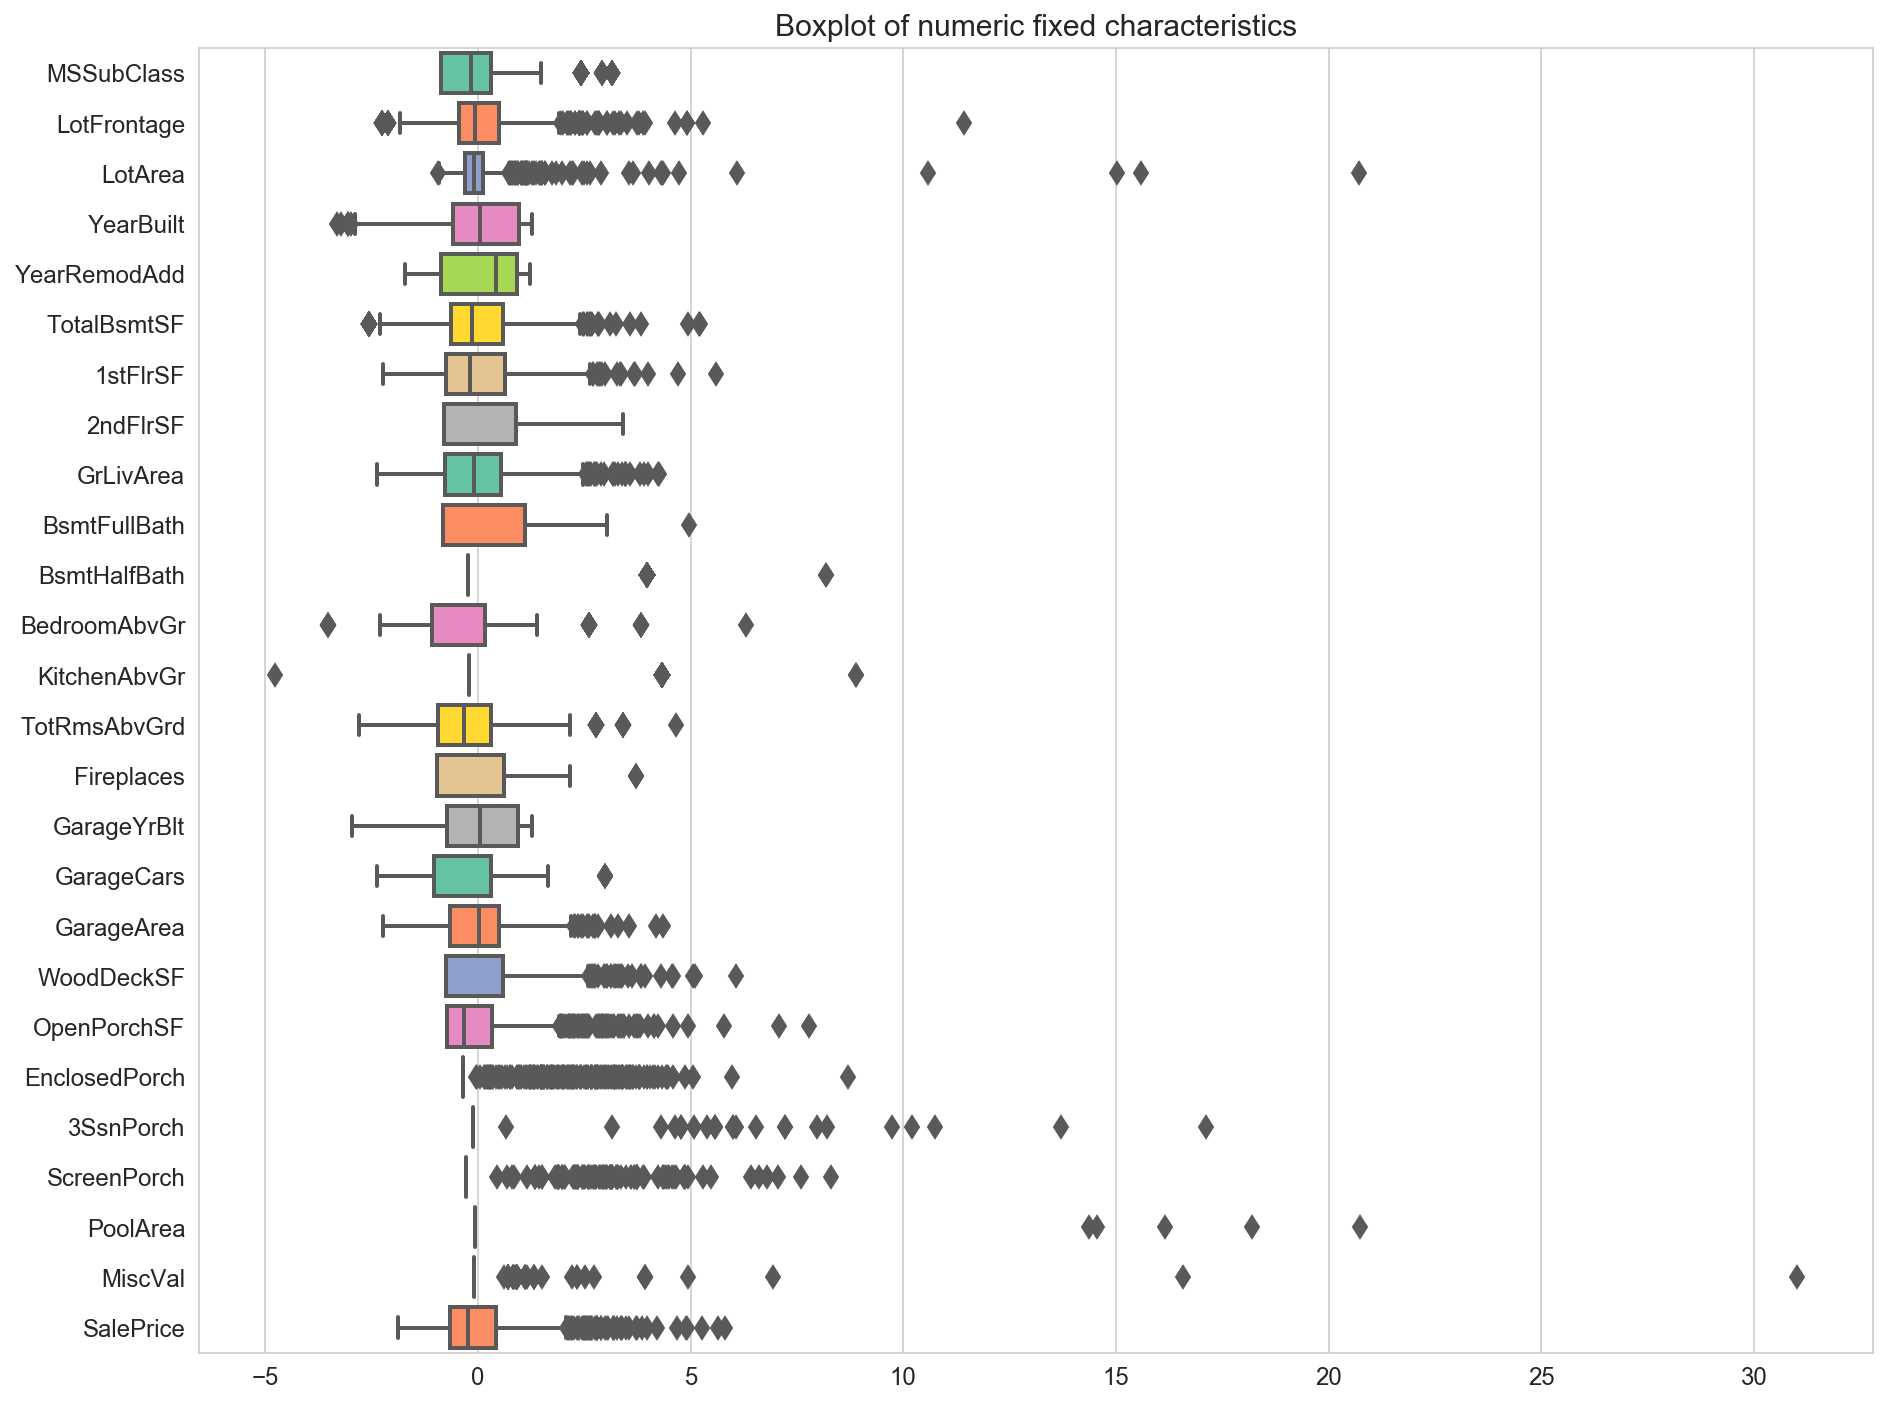

In [45]:
plt.figure(figsize=(15,12))
ax_box = sns.boxplot(data=fixed_numeric_scaled, orient='h', palette="Set2",
            saturation=3, fliersize=8, linewidth=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Boxplot of numeric fixed characteristics', fontsize=15)
plt.show()

Many of the variables that measure area have outliers outside the right whisker. Some of these could be caused by the fact that many of these variables have a large proportion of values equal to zero (eg. no pool, no porch etc). Hence, the few values which are non-zero appear to be outliers. One way to correct this when training the model later is to introduce new dummy variables that indicate whether eg. whether there is a basement or whether there is a porch. 

<h3>Feature Engineering</h3>

**Create dummy variables for categorical variables**

In [46]:
fixed_categorical = ['MSSubClass', 'MSZoning', 'Street', 'Alley',
                     'LotShape', 'LandContour', 'Utilities', 
         'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 
         'Condition2', 'BldgType', 'HouseStyle', 'Foundation', 
        'BsmtQual', 'BsmtExposure', 'GarageType', 'MiscFeature']

In [47]:
house_with_dummies = house[fixed + ['SalePrice', 'YrSold']].copy()
for cat in fixed_categorical:
    if (cat == 'Condition1'):
        house_with_dummies = pd.concat([house_with_dummies, pd.get_dummies(house[cat],prefix='cond1').drop('cond1_Norm', axis=1)], axis=1)
    elif (cat == 'Condition2'):
        house_with_dummies = pd.concat([house_with_dummies, pd.get_dummies(house[cat],prefix='cond2').drop('cond2_Norm', axis=1)], axis=1)
    elif (cat in ['Alley', 'BsmtQual', 'BsmtExposure', 'GarageType', 'MiscFeature']):
        house_with_dummies = pd.concat([house_with_dummies, pd.get_dummies(house[cat],prefix=cat).drop(cat+'_NA', axis=1)], axis=1)
    else:
        house_with_dummies = pd.concat([house_with_dummies, pd.get_dummies(house[cat], prefix=cat, drop_first=True)], axis=1)

In [48]:
# sanity check to make sure number of dummies created is correct
number_dummies = 0
for col in fixed_categorical:
    number_dummies += (len(house[col].unique()) - 1)

# initial num of columns + num of dummies == total num of columns
print (house[fixed + ['SalePrice', 'YrSold']].shape[1] + number_dummies == house_with_dummies.shape[1])

True


In [49]:
# Drop columns that have already been changed to dummies
house_with_dummies.drop(fixed_categorical, axis=1, inplace=True)

In [50]:
house_with_dummies.shape

(1446, 132)

**Create new features**

In [51]:
# Whether there is a basement
house_with_dummies['basement_exists'] = [0 if value == 'NA' else 1 for value in house['BsmtQual']]

In [52]:
# Whether there is a garage
house_with_dummies['garage_exists'] = [0 if value == 'NA' else 1 for value in house['GarageQual']]

In [53]:
# Whether there is a fireplace
house_with_dummies['fireplace_exists'] = [0 if value == 0 else 1 for value in house['Fireplaces']]

In [54]:
# Whether there is a porch (including wood deck)
porch_area = house.loc[:, 'WoodDeckSF':'ScreenPorch'].sum(axis=1)
house_with_dummies['porch_exists'] = [0 if value == 0 else 1 for value in porch_area]

In [55]:
# Whether there is a pool 
house_with_dummies['pool_exists'] = [0 if value == 'NA' else 1 for value in house['PoolQC']]

I created a bed-bathroom interaction term because the number of bedrooms should probably be paired with a suitable number of bathrooms. There should not be too many bathrooms because they would take up unnecessary space and not too few bathrooms, otherwise the occupants have to fight for the bathrooms.

In [56]:
# Bed-Bathroom interaction term
house_with_dummies['bed_bath'] = house['BedroomAbvGr']*house['FullBath']

Using `fireplace_exists` as an example, we can see that houses with fireplace(s) vs no fireplace have different regression lines when we are looking at sale price against living area. This suggests that `fireplace_exists` could be a useful feature to predict price more accurately. 

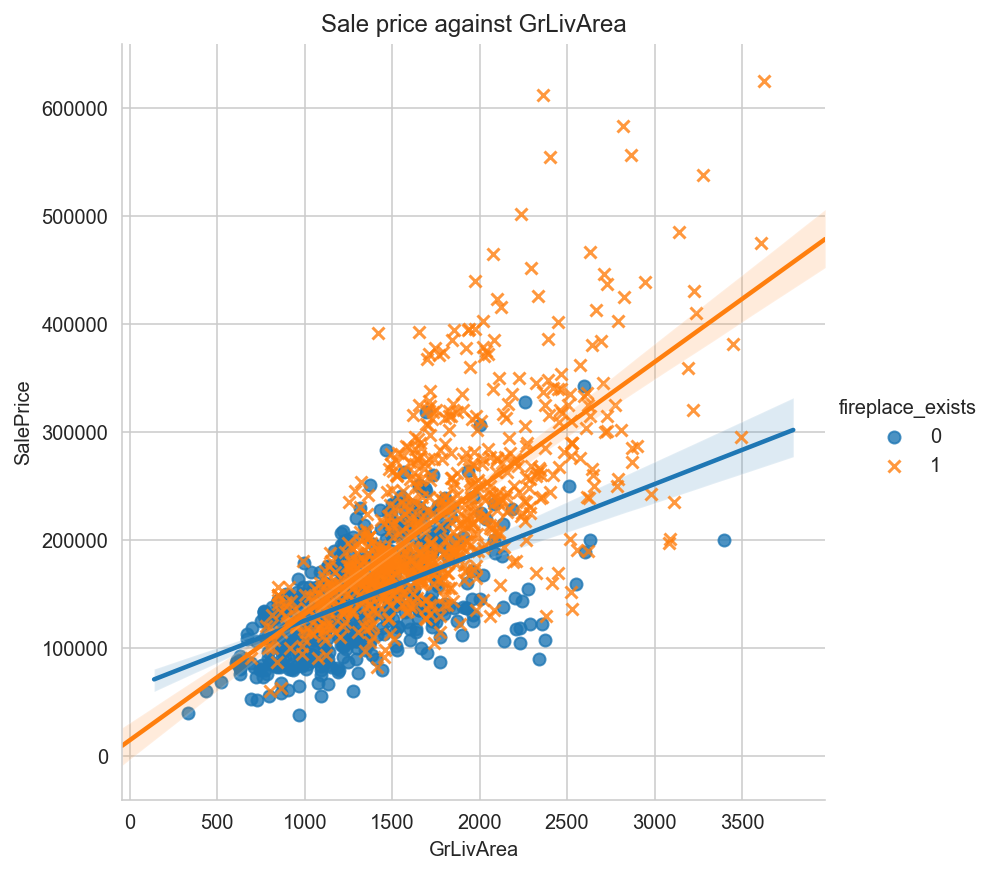

In [57]:
sns.lmplot('GrLivArea', 'SalePrice', data=house_with_dummies, hue='fireplace_exists', markers=["o", "x"], height=6)
plt.title('Sale price against GrLivArea')
plt.show()

<h3>Modelling</h3>

**Split the data into training and testing datasets**

In [58]:
test = house_with_dummies[house_with_dummies['YrSold'] == 2010]
test.shape

(172, 138)

In [59]:
train = house_with_dummies[house_with_dummies['YrSold'] < 2010]
train.shape

(1274, 138)

In [60]:
# training data
y_train = train['SalePrice']
X_train = train.drop(['SalePrice', 'YrSold'], axis=1)

In [61]:
X_train.shape

(1274, 136)

In [62]:
ss = StandardScaler()

**Baseline model**

In [63]:
sse_baseline = np.sum((y_train - y_train.mean())**2)
sse_baseline

7342187063678.477

**Feature selection and model evaluation**

Let's first start with manually selecting some features that we think might contribute to predicting the sale price of houses. We can do this by selecting the features that have a relatively strong correlation with the sale price (as calculated in the EDA section). However, we should avoid using features that have a strong correlation with each other to minimize the multicollinearity. 

For example, we can observe that the `YearBuilt` and `GarageYrBlt` have a correlation of 0.82 (shown below). Therefore, we are going to use `YearBuilt` and not `GarageYrBlt` as a feature. (This is why I did not fill in the null values for `GarageYrBlt`. Hence, it is reasonable to drop this feature. This will also prevent the null values in this column from causing errors later in the regression models.)

We will use these manually selected features in a simple linear regression model.

In [64]:
corr_pairs[(corr_pairs['x1'] == 'YearBuilt') & (corr_pairs['x2'] == 'GarageYrBlt')]

,x1,x2,correlation,magnitude
83,YearBuilt,GarageYrBlt,0.829667,0.829667


In [65]:
X_train.drop('GarageYrBlt', axis=1, inplace=True)

In [66]:
# Standardize the training data
Xs_train = ss.fit_transform(X_train)

/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


**Linear regression model**

> **Note:** The following model that results from the manual selection of features is not meant to be the best. It is just an exercise to choose features and see how the resulting model performs.

In [67]:
linreg = LinearRegression()
selected_features = ['GrLivArea', 'GarageCars', 'TotalBsmtSF', 'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'WoodDeckSF', 'LotArea', 'BsmtFullBath', 'BedroomAbvGr']
X_manual_selection = ss.fit_transform(X_train[selected_features])

/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [68]:
linreg_score = cross_val_score(linreg, X_manual_selection, y_train, cv=10)
print (linreg_score)
linreg_score.mean()

[0.82665819 0.80145171 0.84018833 0.85679067 0.80006504 0.7803582
 0.77062661 0.74319457 0.7383212  0.80840412]


0.7966058633938412

In [69]:
# formula = "SalePrice ~ GrLivArea + GarageCars + TotalBsmtSF + YearBuilt + YearRemodAdd + Fireplaces + WoodDeckSF + LotArea + BsmtFullBath + BedroomAbvGr"
formula = 'SalePrice ~ ' + ' + '.join(selected_features)
model = sm.ols(formula, data=pd.concat([X_train, y_train], axis=1))
results = model.fit()

In [70]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     527.8
Date:                Thu, 18 Apr 2019   Prob (F-statistic):               0.00
Time:                        23:59:45   Log-Likelihood:                -15077.
No. Observations:                1274   AIC:                         3.018e+04
Df Residuals:                    1263   BIC:                         3.023e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -1.72e+06   1.08e+05    -15.980      0.000   -1.93e+06   -1.51e+06
GrLivArea       80.0142      3.039     26.333      0.000      74.053      85.975
GarageCars    1.293e+04   1720.700      7.517      0.000    9558.572    1.63e+04
TotalBsmtSF     41.3537      2.838     14.574      0.000      35.787      46.920
YearBuilt      398.4192     43.919      9.072      0.000     312.257     484.581
YearRemodAdd   477.6618     59.469      8.032      0.000     360.993     594.331
Fireplaces    8636.7685   1746.072      4.946      0.000    5211.248    1.21e+04
WoodDeckSF      18.1615      8.157      2.226      0.026       2.158      34.165
LotArea          0.4392      0.098      4.488      0.000       0.247       0.631
BsmtFullBath  8151.5038   1961.119      4.157      0.000    4304.094     1.2e+04
BedroomAbvGr -1.217e+04   1470.173     -8.277      0.000   -1.51e+04   -9283.659
==============================================================================
Omnibus:                      294.456   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1979.858
Skew:                           0.894   Prob(JB):                         0.00
Kurtosis:                       8.840   Cond. No.                     1.71e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.71e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Using sklearn's LinearRegression and statsmodel's OLS, we get $R^2$ scores of 0.797 and 0.807 respectively. This $R^2$ score is quite good given that we manually selected 10 features. The $R^2$ score of ~0.8 means that this model is able to account for 80% of the variance that is unexplained by the baseline model. Looking at the coefficients, we observe that the `GarageCars`, `Fireplaces`, `BsmtFullBath` and `BedroomAbvGr` have some of the largest magnitudes. This means that these variables affect the sale price more. In addition, the p-value for all the coefficients are less than 0.05, hence we can be sure that the coefficients are statistically different from zero at the 0.05 significance level.

**Feature selection using RFECV**

In [71]:
selector = RFECV(linreg, step=1, cv=10)
selector = selector.fit(Xs_train, y_train)

In [72]:
rfecv_columns = X_train.columns[selector.support_]
print (f"Number of features selected: {selector.n_features_}")
print (rfecv_columns)

Number of features selected: 28
Index(['LotArea', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'Fireplaces', 'GarageCars', 'GarageArea', 'ScreenPorch', 'PoolArea',
       'MSSubClass_120', 'MSSubClass_160', 'LandSlope_Sev',
       'Neighborhood_Crawfor', 'Neighborhood_Mitchel', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Neighborhood_StoneBr',
       'BsmtQual_Ex', 'BsmtExposure_Gd', 'basement_exists', 'pool_exists'],
      dtype='object')


Using RFECV and a linear regression estimator, 28 features were selected. Most of the manually selected features were also selected by RFECV. Next, we use these selected features in a linear regression model and run cross validation on the model.

In [73]:
rfecv_score = cross_val_score(linreg, selector.transform(Xs_train), y_train, cv=10)

In [74]:
print (rfecv_score)
print (f"Linear regression with RFECV selected features: mean: {np.mean(rfecv_score)}, std: {np.std(rfecv_score)}")

[0.8950204  0.85912648 0.90781632 0.89255228 0.88428495 0.86632288
 0.89224253 0.87221155 0.85131625 0.85029092]
Linear regression with RFECV selected features: mean: 0.8771184566991531, std: 0.01905502866125542


**Ridge regression with RFECV selected features**

In [75]:
# Finding the optimal alpha for Ridge
ridgeregcv = RidgeCV(alphas=np.logspace(1,5,500), cv=10)
ridgeregcv.fit(selector.transform(Xs_train), y_train)
print (f"Optimal alpha for ridge: {ridgeregcv.alpha_}")

Optimal alpha for ridge: 31.40465219496752


In [76]:
ridgereg = Ridge(alpha=ridgeregcv.alpha_, random_state=42)

In [77]:
ridge_score = cross_val_score(ridgereg, selector.transform(Xs_train), y_train, cv=10)

In [78]:
print (ridge_score)
print (f"Ridge regression: mean: {np.mean(ridge_score)}, std: {np.std(ridge_score)}")

[0.89894624 0.86689652 0.90792779 0.89119557 0.88239067 0.86739483
 0.89653192 0.87017538 0.8544514  0.84302629]
Ridge regression: mean: 0.877893660616117, std: 0.019864077169895696


**Lasso regression**

In [79]:
# Finding the optimal alpha for Lasso
lassoregcv = LassoCV(n_alphas=500, random_state=42, max_iter=10000, cv=10)
lassoregcv.fit(Xs_train, y_train)
print (f"Optimal alpha for lasso: {lassoregcv.alpha_}")

Optimal alpha for lasso: 345.46504383831854


In [80]:
coeffs = pd.DataFrame(lassoregcv.coef_.reshape(1,len(X_train.columns)), columns=X_train.columns)
coeffs_t = coeffs.transpose()
coeffs_t.columns = ['lasso_coefs']
coeffs_t['magnitude'] = coeffs_t.abs()
coeffs_sorted = coeffs_t.sort_values('magnitude', ascending=False)
coeffs_sorted.head(10)

,lasso_coefs,magnitude
GrLivArea,26120.500065,26120.500065
TotalBsmtSF,13472.798928,13472.798928
BsmtQual_Ex,10543.961137,10543.961137
YearBuilt,9437.699658,9437.699658
Neighborhood_NridgHt,8611.017890,8611.017890
YearRemodAdd,7510.930323,7510.930323
Neighborhood_StoneBr,6715.422916,6715.422916
LotArea,6076.968068,6076.968068
Neighborhood_NoRidge,6019.724302,6019.724302
BsmtExposure_Gd,5564.396620,5564.396620


In [81]:
lasso_columns = coeffs_sorted[coeffs_sorted['magnitude'] > 0].index
print (f"Number of features from lasso regression: {len(lasso_columns)}")
lasso_columns

Number of features from lasso regression: 88


Index(['GrLivArea', 'TotalBsmtSF', 'BsmtQual_Ex', 'YearBuilt',
       'Neighborhood_NridgHt', 'YearRemodAdd', 'Neighborhood_StoneBr',
       'LotArea', 'Neighborhood_NoRidge', 'BsmtExposure_Gd', 'BedroomAbvGr',
       'KitchenAbvGr', 'Neighborhood_Somerst', 'Neighborhood_Crawfor',
       'GarageCars', 'BsmtFullBath', '2ndFlrSF', 'Fireplaces', 'TotRmsAbvGrd',
       'LandSlope_Sev', 'GarageArea', 'BsmtExposure_No', 'BldgType_TwnhsE',
       'ScreenPorch', 'Neighborhood_Mitchel', 'BldgType_Twnhs',
       'MSSubClass_160', 'basement_exists', 'cond2_PosA', 'GarageType_CarPort',
       'Neighborhood_Veenker', 'Neighborhood_BrkSide', 'MSSubClass_120',
       'LotShape_IR2', 'GarageType_BuiltIn', 'LotConfig_CulDSac', 'WoodDeckSF',
       'cond1_RRAe', 'Street_Pave', 'GarageType_2Types', 'Neighborhood_BrDale',
       'OpenPorchSF', 'Neighborhood_Gilbert', 'MSZoning_RM',
       'Neighborhood_ClearCr', '3SsnPorch', 'Neighborhood_Edwards',
       'cond1_Feedr', 'Neighborhood_NPkVill', 'MiscFeatur

Using Lasso, 88 features were selected (magnitude > 0). Next, we use these 88 features in a lasso regression model and run cross validation on the model.

In [82]:
lassoreg = Lasso(alpha=lassoregcv.alpha_, random_state=42)

In [83]:
lasso_score = cross_val_score(lassoreg, ss.fit_transform(X_train[lasso_columns]), y_train, cv=10)

/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [84]:
print (lasso_score)
print (f"Lasso regression: mean: {np.mean(lasso_score)}, std: {np.std(lasso_score)}")

[0.89960007 0.85514652 0.91089271 0.89016896 0.88628235 0.86766781
 0.89651375 0.86767105 0.85664939 0.84522645]
Lasso regression: mean: 0.8775819049262749, std: 0.020908999332396254


**Comparing the 3 models**

The mean $R^2$ score (10-fold cross validation) for the models (in descending order):
1. Ridge regression (alpha = 31.4) using 28 RFECV selected features: 0.87789
2. Lasso regression (alpha = 345.5) using 88 features: 0.87758 
3. Linear regression using 28 RFECV selected features: 0.87712

The best model is the Ridge regression model. We will use this model to test the perfomance on 2010 house sale prices later.

In [85]:
# Train the ridge regression model on the training data
ridgereg.fit(selector.transform(Xs_train), y_train)

Ridge(alpha=31.40465219496752, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001)

In [86]:
coeffs_ridge = pd.DataFrame(ridgereg.coef_.reshape(1,len(rfecv_columns)), columns=rfecv_columns)
coeffs_ridge_t = coeffs_ridge.transpose()
coeffs_ridge_t.columns = ['ridge_coefs']
coeffs_ridge_t['magnitude'] = coeffs_ridge_t.abs()
coeffs_ridge_sorted = coeffs_ridge_t.sort_values('magnitude', ascending=False)
coeffs_ridge_sorted

,ridge_coefs,magnitude
GrLivArea,17567.611072,17567.611072
TotalBsmtSF,14482.917180,14482.917180
2ndFlrSF,13910.642791,13910.642791
BsmtQual_Ex,11199.851759,11199.851759
YearBuilt,9970.928558,9970.928558
Neighborhood_NridgHt,9082.194976,9082.194976
YearRemodAdd,8418.270119,8418.270119
1stFlrSF,7721.149438,7721.149438
Neighborhood_StoneBr,7511.831291,7511.831291
BsmtExposure_Gd,6657.344454,6657.344454


From the coefficients with the largest magnitudes, it can be observed that 
1. the size of the area of the different spaces (eg. living area, basement, 1st floor, 2nd floor)
2. the year the house was built / remodeled
3. the neighborhood 

are the important predictors that affect the sale price. For example, for every unit increase (which is 1 standard deviation because it is normalized) in `GrLivArea`, the sale price is estimated to increase by $17567. In general, newer houses with larger areas in Northridge Heights and Stone Brook would have higher sale prices.

Nevertheless, I note that some of the variables are relatively strongly correlated. This could introduce multicollinearity into the model and violate the independence assumption. Thus, the coefficients of the model might change drastically given changes in the predictors. However, in this business context, we are primarily interested in using the model to estimate the sale price and not the effect of each fixed characteristic on the sale price. Therefore, it would be reasonable to get better model performance by introducing some multicollinearity. However, in the second question, we need to be able to interpret the coefficients accurately for each feature because we need to consider which feature to renovate.

**Evaluate performance on 2010 houses**

> **Note:** Standardize the test design matrix using the StandardScaler fit on the training set.

In [87]:
ss.fit(X_train[rfecv_columns])
Xs_test = ss.transform(test[rfecv_columns])
y_test = test['SalePrice']
test_score = ridgereg.score(Xs_test, y_test)
print (f"Test score: {test_score}")

Test score: 0.8808281842444843


/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  


The Ridge model chosen is quite good as the $R^2$ test score on the 2010 houses is 0.88. This is consistent with the scores obtained during cross validation. This means that the model is able to generalise and predict sale prices for unseen data quite well.

**Calculate the residuals**

In [88]:
y_train_pred = ridgereg.predict(selector.transform(Xs_train))

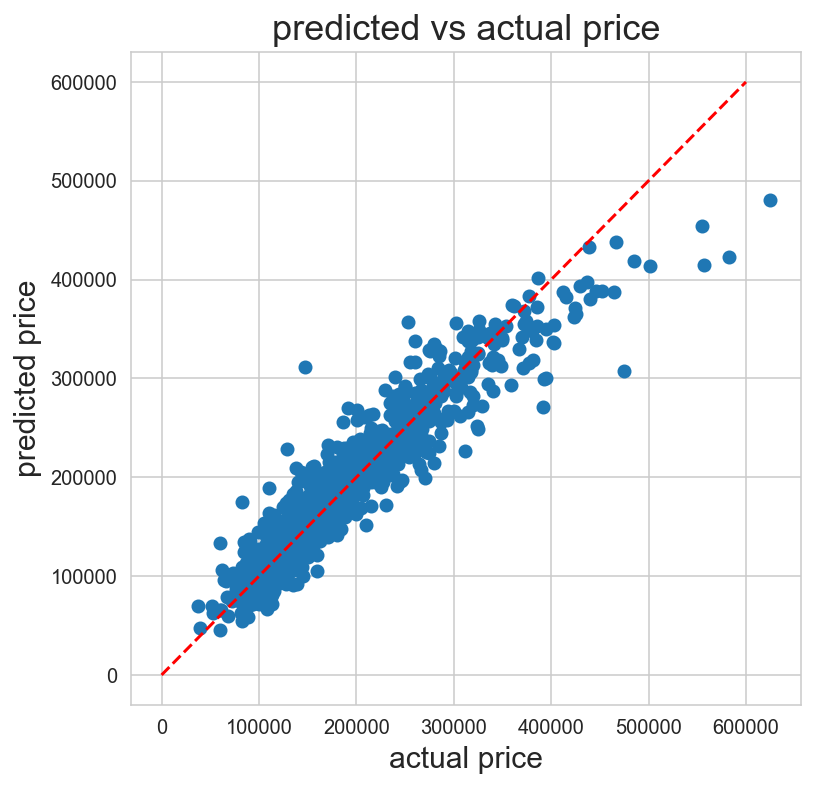

In [89]:
plt.figure(figsize=(6,6))
plt.scatter(y_train, y_train_pred)
plt.plot([0, 600000], [0,600000], color='r', ls="--")
plt.xlabel('actual price', fontsize=15)
plt.ylabel('predicted price', fontsize=15)
plt.title('predicted vs actual price', fontsize=18)
plt.show()

In [90]:
residuals_train = y_train - y_train_pred

/Users/joshuamei/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


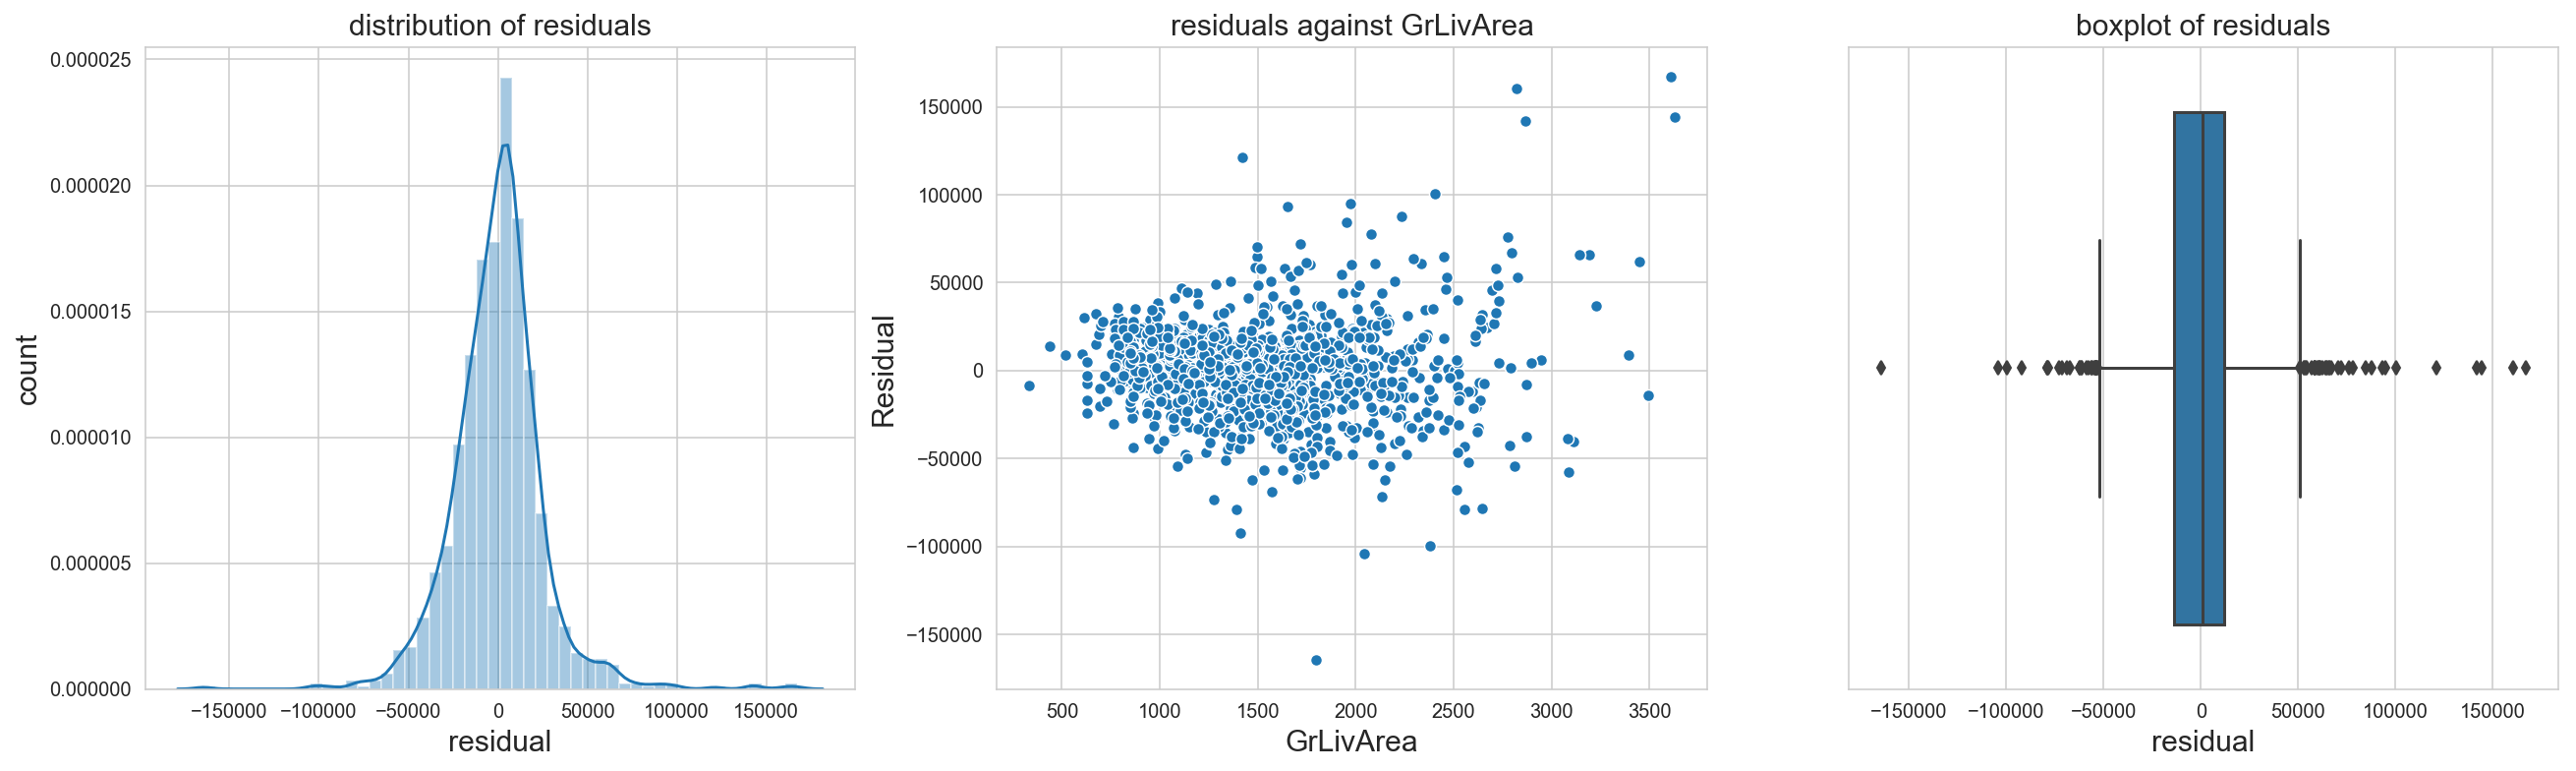

In [91]:
plt.figure(figsize=(22,6))
plt.subplot(131)
sns.distplot(residuals_train)
plt.xlabel('residual', fontsize=15)
plt.ylabel('count', fontsize=15)
plt.title('distribution of residuals', fontsize=15)

plt.subplot(132)
sns.scatterplot(house_with_dummies['GrLivArea'], residuals_train)
plt.xlabel('GrLivArea', fontsize=15)
plt.ylabel('Residual', fontsize=15)
plt.title('residuals against GrLivArea', fontsize=15)

plt.subplot(133)
sns.boxplot(residuals_train)
plt.xlabel('residual', fontsize=15)
plt.title('boxplot of residuals', fontsize=15)

plt.show()

From the distribution plot, it can be observed that the residuals follow an approximately normal distribution. This satisfies the normality assumption in the MLR model. However, the variance of the residuals at each value of GrLivArea seems to inconsistent. This violates the assumption of equality of variance.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

**EDA & Feature Engineering for second model**

In the second model, the target will be the residuals (because it represent the variance in price unexplained by the fixed characteristics). The design matrix will comprise the non-fixed, easy-to-change aspects of the house.

I chose `BsmtFinSF1`, `BsmtFinSF2`, `BsmtUnfSF` as non-fixed characteristics because by doing renovation, the basement finished area could be increased and the unfinished area would decrease. I also interpreted `LowQualFinSF` as the area of low quality finished space; by renovating the space, the low quality could be changed to a high quality living space which would reduce the `LowQualFinSF`.

In [92]:
non_fixed = ['OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 
             'ExterCond', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 
             'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 
             'Fence', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF']

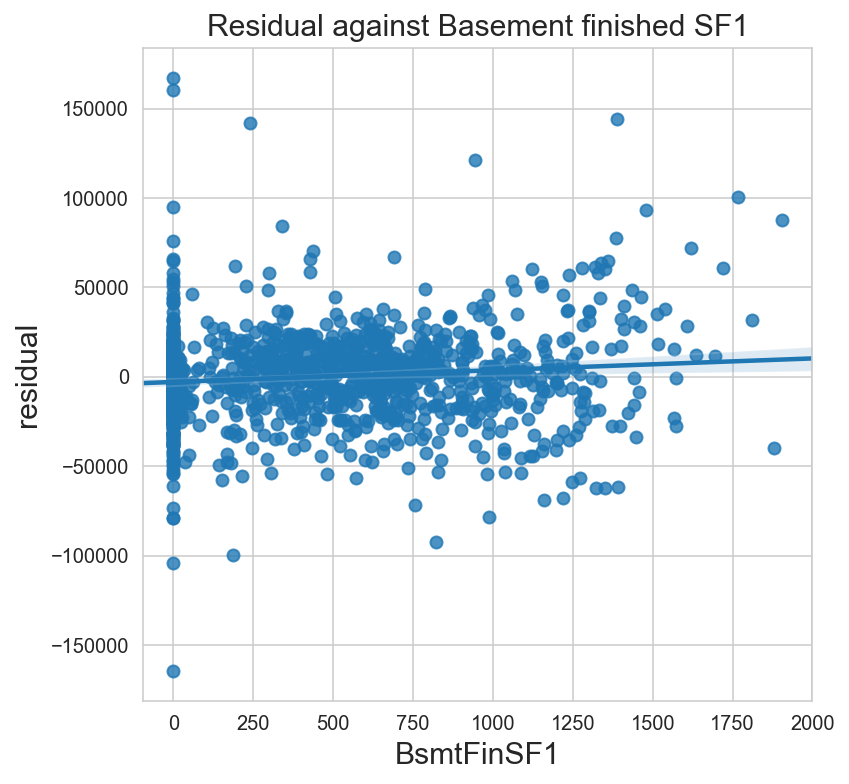

In [93]:
plt.figure(figsize=(6,6))
sns.regplot(house[house['YrSold'] < 2010]['BsmtFinSF1'], residuals_train)
plt.ylabel('residual', fontsize=15)
plt.xlabel('BsmtFinSF1', fontsize=15)
plt.title('Residual against Basement finished SF1', fontsize=15)
plt.show()

In [94]:
non_fixed_numeric = ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF']

In [95]:
listCorrelationPairs(pd.concat([house[house['YrSold'] < 2010][non_fixed_numeric], residuals_train], axis=1).corr())

,x1,x2,correlation,magnitude
6,BsmtFinSF1,BsmtUnfSF,-0.537783,0.537783
0,MasVnrArea,BsmtFinSF1,0.220045,0.220045
9,BsmtFinSF2,BsmtUnfSF,-0.197318,0.197318
8,BsmtFinSF1,SalePrice,0.111013,0.111013
2,MasVnrArea,BsmtUnfSF,0.107771,0.107771
13,BsmtUnfSF,SalePrice,-0.076574,0.076574
4,MasVnrArea,SalePrice,0.073981,0.073981
3,MasVnrArea,LowQualFinSF,-0.070206,0.070206
7,BsmtFinSF1,LowQualFinSF,-0.064146,0.064146
1,MasVnrArea,BsmtFinSF2,-0.061917,0.061917


It seems like the correlations between the numeric non-fixed variables and the sale price are not strong. These variables might not be very good in explaining the remaining price variance.

For the categorical features, there are variables that are related to each other; in order to reduce the multicollinearity in the model, I would attempt to choose variables that are not closely related to each other. This is so that the resulting coefficients in the model can be used with more confidence when determining the value of renovating the feature.

I am not including `OverallCond` or `OverallQual` because they are not features of a house which can be renovated per se. Instead, I will include the other individual features that can be renovated (which will affect overall quality and condition). I will also include the either only the quality or condition of the a house feature because they are closely related. 

> **Note:** Including `OverallCond` and `OverallQual` would improve the $R^2$ score but it might introduce more multicollinearity into the model

In [96]:
non_fixed_categorical = ['RoofStyle', 'Exterior1st', 'MasVnrType', 'ExterCond', 'BsmtCond', 'Heating', 'CentralAir', 'Electrical', 'KitchenQual',
                        'Functional', 'FireplaceQu', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence']

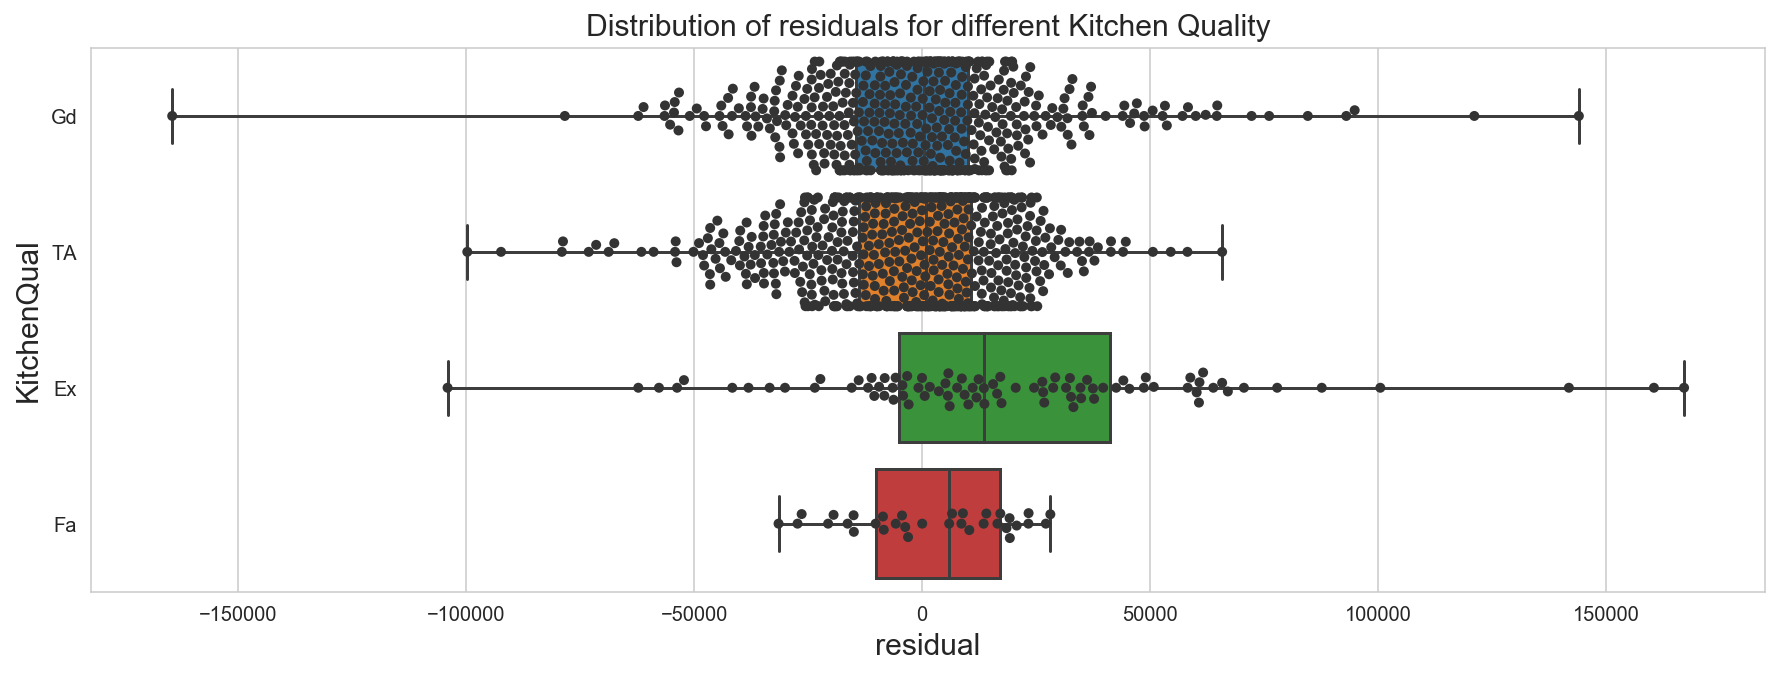

In [97]:
plt.figure(figsize=(15,5))
sns.boxplot(x=residuals_train, y=house[house['YrSold'] < 2010]['KitchenQual'], whis=np.inf)
sns.swarmplot(x=residuals_train, y=house[house['YrSold'] < 2010]['KitchenQual'], color=".2")
plt.xlabel('residual', fontsize=15)
plt.ylabel('KitchenQual', fontsize=15)
plt.title('Distribution of residuals for different Kitchen Quality', fontsize=15)
plt.show()

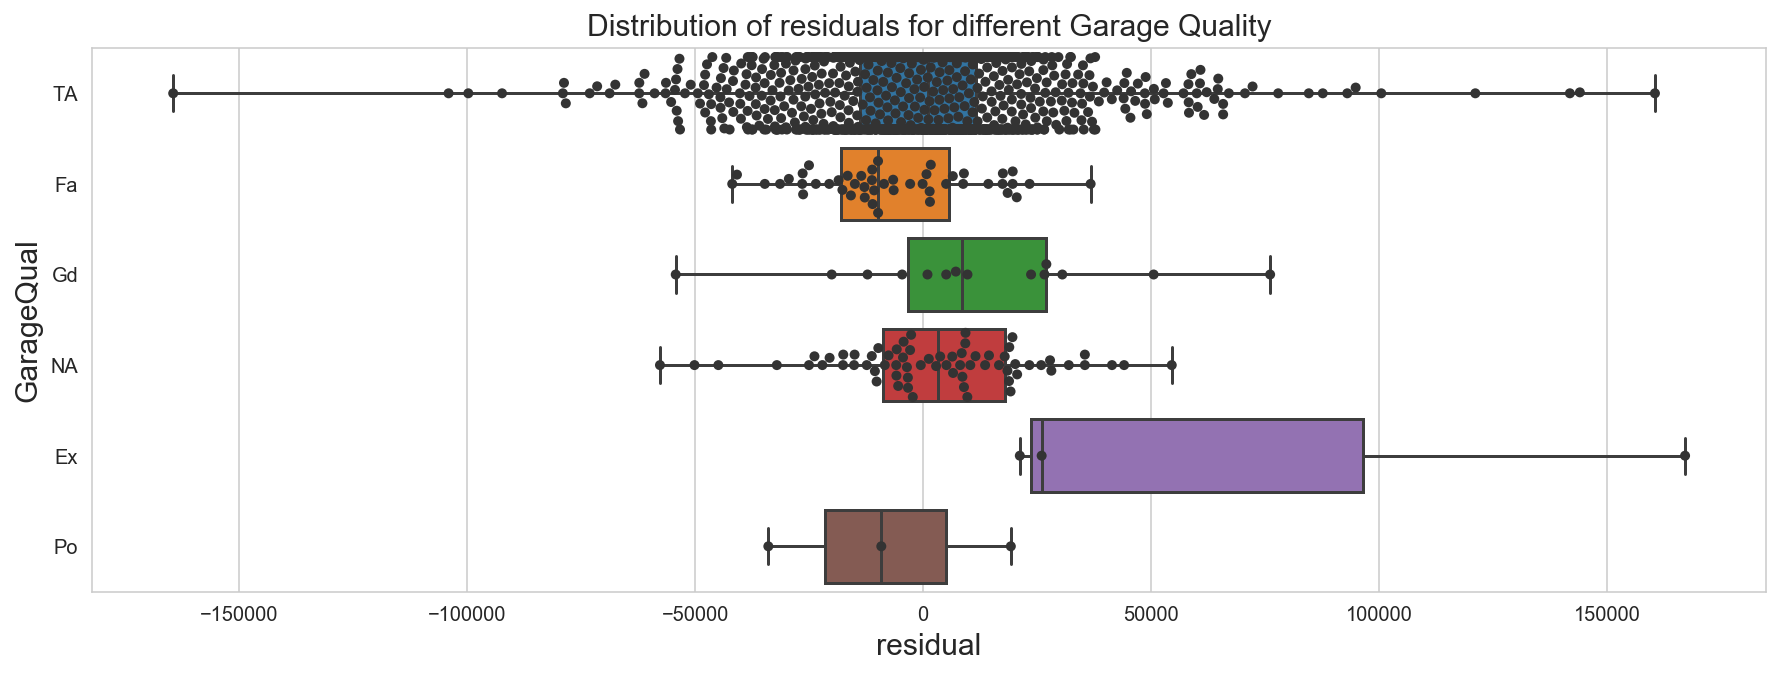

In [98]:
plt.figure(figsize=(15,5))
sns.boxplot(x=residuals_train, y=house[house['YrSold'] < 2010]['GarageQual'], whis=np.inf)
sns.swarmplot(x=residuals_train, y=house[house['YrSold'] < 2010]['GarageQual'], color=".2")
plt.xlabel('residual', fontsize=15)
plt.ylabel('GarageQual', fontsize=15)
plt.title('Distribution of residuals for different Garage Quality', fontsize=15)
plt.show()

For the `KitchenQual` variable, it seems that the distributions of the residuals in each category are rather similar, so it might not be a good predictor. For the `GarageQual` variable, the distributions of the residuals are more varied which suggests that it might be a good predictor to explain the remaining variance in price.

In [99]:
# Dummifying the categorical variables
non_fixed_X = house[non_fixed_numeric + non_fixed_categorical + ['YrSold']].copy()
for cat in non_fixed_categorical:
    if (cat == 'MasVnrType'):
        non_fixed_X = pd.concat([non_fixed_X, pd.get_dummies(house[cat],prefix=cat).drop(cat+'_None', axis=1)], axis=1)
    elif (cat in ['OverallQual', 'OverallCond']):
        non_fixed_X = pd.concat([non_fixed_X, pd.get_dummies(house[cat],prefix=cat).drop(cat+'_5', axis=1)], axis=1)
    elif (cat in ['ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual']):
        non_fixed_X = pd.concat([non_fixed_X, pd.get_dummies(house[cat],prefix=cat).drop(cat+'_TA', axis=1)], axis=1)
    elif (cat == 'CentralAir'):
        non_fixed_X = pd.concat([non_fixed_X, pd.get_dummies(house[cat],prefix=cat).drop(cat+'_N', axis=1)], axis=1)
    elif (cat in ['BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence']):
        non_fixed_X = pd.concat([non_fixed_X, pd.get_dummies(house[cat],prefix=cat).drop(cat+'_NA', axis=1)], axis=1)
    else:
        non_fixed_X = pd.concat([non_fixed_X, pd.get_dummies(house[cat], prefix=cat, drop_first=True)], axis=1)

In [100]:
# sanity check to make sure number of dummies created is correct
number_dummies = 0
for col in non_fixed_categorical:
    number_dummies += (len(house[col].unique()) - 1)

print (house[non_fixed_numeric + non_fixed_categorical + ['YrSold']].shape[1] + number_dummies == non_fixed_X.shape[1])

True


In [101]:
# Drop columns that have already been changed to dummies
non_fixed_X.drop(non_fixed_categorical, axis=1, inplace=True)

In [102]:
non_fixed_X.shape

(1446, 74)

In [103]:
# Design matrix for testing
non_fixed_X_test = non_fixed_X[non_fixed_X['YrSold'] == 2010]
non_fixed_X_test.shape

(172, 74)

In [104]:
# Design matrix for training
non_fixed_X_train = non_fixed_X[non_fixed_X['YrSold'] < 2010].copy()
non_fixed_X_train.drop('YrSold', axis=1, inplace=True)
non_fixed_X_train.shape

(1274, 73)

In [105]:
# Standardization
non_fixed_Xs_train = ss.fit_transform(non_fixed_X_train)

/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


**Feature selection with RFECV**

In [106]:
selector2 = RFECV(linreg, step=1, cv=10, min_features_to_select=1)
selector2.fit(non_fixed_Xs_train, residuals_train)

RFECV(cv=10,
   estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
   min_features_to_select=1, n_jobs=None, scoring=None, step=1, verbose=0)

In [107]:
non_fixed_rfecv_columns = non_fixed_X_train.columns[selector2.support_]
print (f"Number of selected features: {selector2.n_features_}")
print (non_fixed_rfecv_columns)

Number of selected features: 4
Index(['BsmtUnfSF', 'Exterior1st_BrkFace', 'KitchenQual_Ex', 'Functional_Typ'], dtype='object')


In [108]:
non_fixed_rfecv_score = cross_val_score(linreg, selector2.transform(non_fixed_Xs_train), residuals_train, cv=10)
print (non_fixed_rfecv_score)
print (f"Linear regression: mean: {np.mean(non_fixed_rfecv_score)}, std: {np.std(non_fixed_rfecv_score)}")

[0.0217269  0.03893628 0.2061969  0.0796166  0.1695578  0.03981856
 0.01828653 0.12512974 0.13548086 0.11466494]
Linear regression: mean: 0.09494151056448832, std: 0.06207695089628637


**Ridge regression with RFECV selected features**

In [109]:
# Finding optimal alpha for Ridge
non_fixed_ridgeregcv = RidgeCV(alphas=np.logspace(1,5,500), cv=10)
non_fixed_ridgeregcv.fit(selector2.transform(non_fixed_Xs_train), residuals_train)
print (f"Optimal alpha for ridge: {non_fixed_ridgeregcv.alpha_}")

Optimal alpha for ridge: 98.62521794868779


In [110]:
non_fixed_ridgereg = Ridge(alpha=non_fixed_ridgeregcv.alpha_, random_state=42)
non_fixed_ridge_score = cross_val_score(non_fixed_ridgereg, selector2.transform(non_fixed_Xs_train), residuals_train, cv=10)

In [111]:
print (non_fixed_ridge_score)
print (f"Ridge regression: mean: {np.mean(non_fixed_ridge_score)}, std: {np.std(non_fixed_ridge_score)}")

[0.03039687 0.04400684 0.19795265 0.07966946 0.1645894  0.04695383
 0.0276102  0.12647788 0.129033   0.11195413]
Ridge regression: mean: 0.09586442428079608, std: 0.05632913530931385


**Lasso regression**

In [112]:
# Finding optimal alpha for Lasso
non_fixed_lassoregcv = LassoCV(n_alphas=500, random_state=42, max_iter=10000, cv=10)
non_fixed_lassoregcv.fit(non_fixed_Xs_train, residuals_train)
print (f"Optimal alpha for lasso: {non_fixed_lassoregcv.alpha_}")

Optimal alpha for lasso: 981.3808623177918


In [113]:
non_fixed_coeffs_t = pd.DataFrame(non_fixed_lassoregcv.coef_.reshape(1,len(non_fixed_X_train.columns)), columns=non_fixed_X_train.columns).transpose()
non_fixed_coeffs_t.columns = ['lasso_coefs']
non_fixed_coeffs_t['magnitude'] = non_fixed_coeffs_t.abs()
non_fixed_coeffs_sorted = non_fixed_coeffs_t.sort_values('magnitude', ascending=False)
non_fixed_coeffs_sorted.head(10)

,lasso_coefs,magnitude
KitchenQual_Ex,4395.895707,4395.895707
Functional_Typ,3983.115858,3983.115858
Exterior1st_BrkFace,2824.531557,2824.531557
BsmtUnfSF,-1808.777481,1808.777481
Functional_Sev,-1227.755766,1227.755766
ExterCond_Ex,963.960662,963.960662
BsmtCond_Fa,-902.365875,902.365875
PoolQC_Gd,670.056410,670.056410
MasVnrType_BrkCmn,-598.453517,598.453517
PoolQC_Ex,-177.237214,177.237214


In [114]:
non_fixed_lasso_columns = non_fixed_coeffs_sorted[non_fixed_coeffs_sorted['magnitude'] > 0].index
print (f"Number of features from lasso regression: {len(non_fixed_lasso_columns)}")
non_fixed_lasso_columns

Number of features from lasso regression: 18


Index(['KitchenQual_Ex', 'Functional_Typ', 'Exterior1st_BrkFace', 'BsmtUnfSF',
       'Functional_Sev', 'ExterCond_Ex', 'BsmtCond_Fa', 'PoolQC_Gd',
       'MasVnrType_BrkCmn', 'PoolQC_Ex', 'BsmtFinSF2', 'Functional_Maj2',
       'Exterior1st_CemntBd', 'Exterior1st_BrkComm', 'PoolQC_Fa',
       'Heating_OthW', 'Exterior1st_Stucco', 'MasVnrArea'],
      dtype='object')

In [115]:
# Using the features from lasso in the model
non_fixed_lassoreg = Lasso(alpha=non_fixed_lassoregcv.alpha_, random_state=42)
non_fixed_lasso_score = cross_val_score(non_fixed_lassoreg, ss.fit_transform(non_fixed_X_train[non_fixed_lasso_columns]), residuals_train, cv=10)

/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [116]:
print (non_fixed_lasso_score)
print (f"Lasso regression: mean: {np.mean(non_fixed_lasso_score)}, std: {np.std(non_fixed_lasso_score)}")

[0.03135029 0.04558347 0.17567878 0.06562475 0.16028137 0.06431954
 0.03108459 0.14074111 0.11402959 0.099062  ]
Lasso regression: mean: 0.09277554887830786, std: 0.05057150440746269


**Comparing the 3 models**

The mean $R^2$ score (10-fold cross validation) for the models (in descending order):
1. Ridge regression (alpha = 98.6) using 4 RFECV selected features: 0.0959
2. Linear regression using 4 RFECV selected features: 0.0949
3. Lasso regression (alpha = 981.4) using 18 features: 0.0928

The best model is the Ridge regression model. It can be observed that the standard deviation is quite big relative to the mean. This implies that there is some inconsistency in the scores among the different folds. Possible explanations could be outliers in the data or overfitting of the model.

**Evaluate performance of the second model on 2010 houses**

In [117]:
# Train the ridge regression model
non_fixed_ridgereg.fit(selector2.transform(non_fixed_Xs_train), residuals_train)

Ridge(alpha=98.62521794868779, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001)

In [118]:
ss.fit(non_fixed_X_train[non_fixed_rfecv_columns])
non_fixed_Xs_test = ss.transform(non_fixed_X_test[non_fixed_rfecv_columns]) # Standardize the test design matrix
non_fixed_y_test = y_test - ridgereg.predict(Xs_test) # Calculate the y_test for the second model
non_fixed_test_score = non_fixed_ridgereg.score(non_fixed_Xs_test, non_fixed_y_test)
print (f"Test score: {non_fixed_test_score}")

Test score: 0.13970006284055458


/Users/joshuamei/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/joshuamei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  


The score on the 2010 houses is slightly higher than the score obtained from cross validation. However, this is not surprising given the high standard deviation of the cross validation scores. In general, we can see that the score is quite low (~0.1) which implies that the non-fixed characteristics explain about 10% of the variance in the price remaining.

In [119]:
renovate = pd.DataFrame(non_fixed_ridgereg.coef_.reshape(1,len(non_fixed_rfecv_columns)), columns=non_fixed_rfecv_columns).transpose()
renovate.columns = ['coef']
renovate

,coef
BsmtUnfSF,-2642.568740
Exterior1st_BrkFace,3616.361618
KitchenQual_Ex,5113.906878
Functional_Typ,4983.747650


There are 4 renovate-able features of the house: basement unfinished area, house exterior, kitchen quality and home functionality. Based on the coefficients,

* When the basement unfinished area is decreased by one unit (equivalent to 1 standard deviation), an estimated \\$2643 is added to the house value added. Thus, renovating the basement unfinished area to become a finished area would be worthwhile if the renovation cost per unit is less than $2643.

* Having a brick face exterior as compared to the other exterior coverings would add \\$3636 to the house value.

* Having an excellent kitchen quality as compared to a non-excellent kitchen quality would add \\$5114 to the house value.

* Having a typical home functionality compared to the other home functionalities would add \\$4984 to the house value.

One concern is that the categorical variables might not be independent. Thus, I used the chi square test below to find determine if variables are independent.

In [120]:
cat1 = []
cat2 = []
chi2_value = []
chi2_mag = []
p_val = []
predictors = ['Exterior1st', 'KitchenQual', 'Functional']
for i in range(len(predictors)):
    for j in range(i+1,len(predictors)):
        cat1.append(predictors[i])
        cat2.append(predictors[j])
        chi2, p, dof, ex = stats.chi2_contingency(house.groupby([predictors[i], predictors[j]]).size().unstack().fillna(0))
        chi2_value.append(chi2)
        chi2_mag.append(np.abs(chi2))
        p_val.append(p)

chi2_pairs = pd.DataFrame({'cat1': cat1, 'cat2': cat2, 'chi2_statistic': chi2_value,
                      'magnitude': chi2_mag, 'p_val': p_val})

chi2_pairs = chi2_pairs[chi2_pairs['p_val'] <= 0.05]

In [121]:
chi2_pairs

,cat1,cat2,chi2_statistic,magnitude,p_val
0,Exterior1st,KitchenQual,404.842851,404.842851,7.471704e-61
1,Exterior1st,Functional,159.864672,159.864672,1.188095e-06
2,KitchenQual,Functional,51.147136,51.147136,5.053635e-05


From the chi square test it *seems* like the 3 categorical variables are not independent because the p-value is smaller than 0.05 significance level. However, if we look at the observed frequencies below, it can be seen that there are many zeros. According to the documentation guideline, the test is only valid if the observed and expected frequency in each cell is at least 5. Therefore, the test statistic may not be accurate.

In [122]:
house.groupby(['Exterior1st', 'KitchenQual']).size().unstack().fillna(0)

KitchenQual,Ex,Fa,Gd,TA
Exterior1st,,,,
AsbShng,0.0,3.0,2.0,14.0
AsphShn,0.0,0.0,0.0,1.0
BrkComm,0.0,1.0,0.0,1.0
BrkFace,4.0,0.0,13.0,32.0
CBlock,0.0,0.0,0.0,1.0
CemntBd,20.0,1.0,20.0,19.0
HdBoard,0.0,1.0,70.0,150.0
ImStucc,0.0,0.0,1.0,0.0
MetalSd,8.0,9.0,54.0,144.0


With these two models, we can predict the sale price of the house based on the `price predicted from the first model` + `additional value predicted from the second model`. Then, we need to compare the predicted sale price to the total cost of buying the house and renovating the house. If the predicted sale price is greater than the cost, then the house is worth flipping.

As a realtor, I would trust the first model to give an initial estimate of the sale price because the fixed characteristics account for 80% of the price and can provide quite a good estimate. This would help me to quickly make an initial assessment on whether the company should buy the house. However, I would not depend on the second model to decide whether/how the company should renovate the house because the renovate-able features do not account for the variance in the remaining price well enough. Furthermore, there is a high standard deviation in the cross validation scores which implies that the model may not performance consistently.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [123]:
# A: